# Discrete Task:
- Load data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from saxpy.sax import sax_via_window
from tslearn.piecewise import SymbolicAggregateApproximation
from helper_functions.discrete_helper_functions import *
from helper_functions.comparison_helper_functions import *

# Load the datasets from the saved numpy arrays in the Familiarization task
X = np.load('./data/train_data.npy')
y = np.load('./data/actual_train_labels.npy')

X_test = np.load('./data/test_data.npy')

train_data = pd.read_pickle('./data/train_data_df.pkl')

# Seperate the two training datasets
# X1, y1 = training data and labels 1 (normal behaviour)
# X2, y2 = training data and labels 2 (attacks present)
num = 8761
X1 = X[:num]
X2 = X[num:]
y1 = y[:num]
y2 = y[num:]

ss = StandardScaler()
X1_scaled = ss.fit_transform(X1)
X2_scaled = ss.fit_transform(X2)

# Check that everything is there
print("Training dataset shape: ", X.shape)
print("Test dataset shape: ", X_test.shape)
print("Number of attacks: ", np.sum(y==1))

Training dataset shape:  (12938, 40)
Test dataset shape:  (2089, 40)
Number of attacks:  492


## Discrete Method

#### Sybmolic Aggregate Approximation
We commence by a simple demonstration of the applied method. We are using Symbolic Aggregate Approximation (or just SAX) for the discretization of the original, raw signal. SAX originall applies Piecewise Aggregate Approximation (PAA), separating the supplied signal into segments and then based on the mean value of the signal within each segment is assigns each segment a state based on the alphabet size, which is the number of quantized states used for the discretization.

The following plot provides a demonstration of the method on a window of the input signal (in this case scaled `L_T1`) of length=48, extracting 8 segments and assigning them states from the 3 available.

[[[0]
  [0]
  [1]
  [2]
  [2]
  [2]
  [2]
  [1]]]


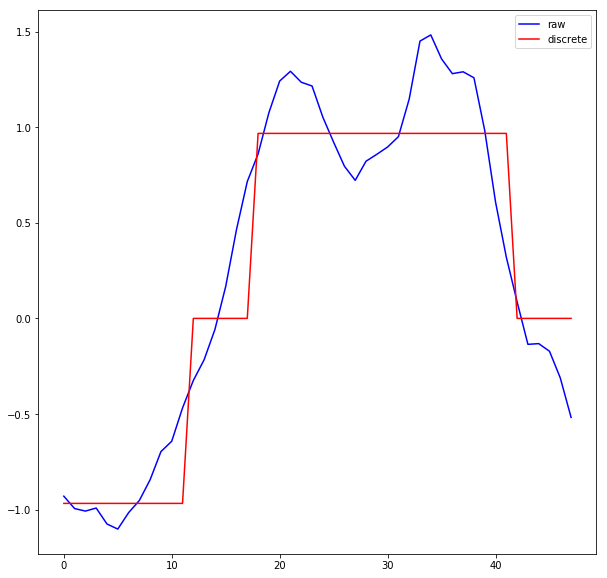

In [54]:
offset = 10
window_size = 48
raw_data = X1_scaled[offset: offset+window_size, 0]

n_sax_symbols = 3
sax = SymbolicAggregateApproximation(n_segments=8, alphabet_size_avg=n_sax_symbols)
sax_dataset = sax.fit_transform(raw_data)
sax_dataset_inv = sax.inverse_transform(sax_dataset)

print(sax_dataset)
plt.figure(figsize = (10,10))
plt.plot(raw_data, color = 'b', label = 'raw')
plt.plot(sax_dataset_inv[0], color = 'r', label = 'discrete')
plt.legend()

In [30]:
# Discretise train and test signal
train_sax=sax_via_window(X1[:, 0], 48, 8, alphabet_size=3,
               nr_strategy='none', z_threshold=0.01)
test_sax = sax_via_window(X2[:,0], 48, 8, alphabet_size=3,
                         nr_strategy='none')

In [28]:
signal = X1_scaled[:, 0]
window_size = 40
paa_segments = 8
alphabet_size = 3

def discretize(raw_signal, window_size, paa_segments, alphabet_size):
    sax = SymbolicAggregateApproximation(n_segments=paa_segments, alphabet_size_avg=alphabet_size)
    discrete_signal = []
    num = len(signal)//window_size
    
    for i in range(num):
        raw = raw_signal[i*window_size : (i+1)*window_size]
        disc = sax.inverse_transform(sax.fit_transform(raw_data))
        discrete_signal.append(np.squeeze(disc))
    discrete_signal = [x for sublist in discrete_signal for x in sublist]
    
    return discrete_signal

discrete_signal = discretize(signal, window_size, paa_segments, alphabet_size)

NameError: name 'SymbolicAggregateApproximation' is not defined

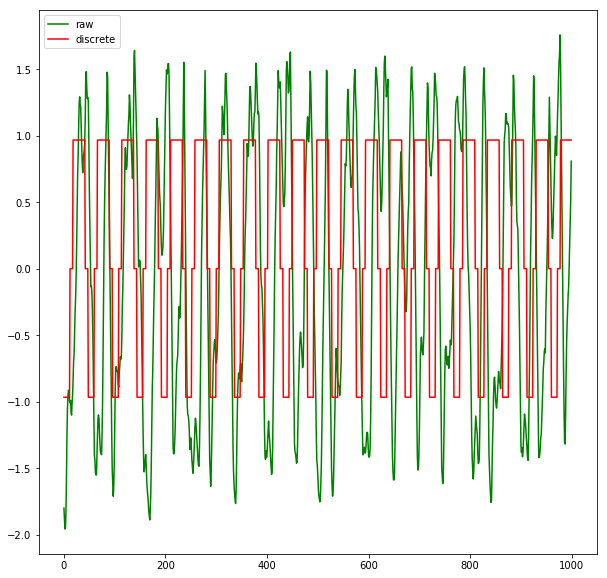

In [5]:
plt.figure(figsize=(10,10))
plt.plot(signal[:1000], color='g', label = 'raw')
plt.plot(discrete_signal[:1000], color='r', label = 'discrete')
plt.legend()

In [6]:
def discretizeV2(raw_signal, window_size, paa_segments):
    discrete_signal = []
    num = window_size//paa_segments

    for i in range(0, len(signal), window_size):
        for ngram in list(train_sax.keys()):
            if i in train_sax[ngram]:
                for n in range(8):
                    discrete_signal.append(np.tile(ngram[n], num))

    discrete_signal = [x for sublist in discrete_signal for x in sublist]
    return discrete_signal

discrete_signal = discretizeV2(signal, window_size, paa_segments)

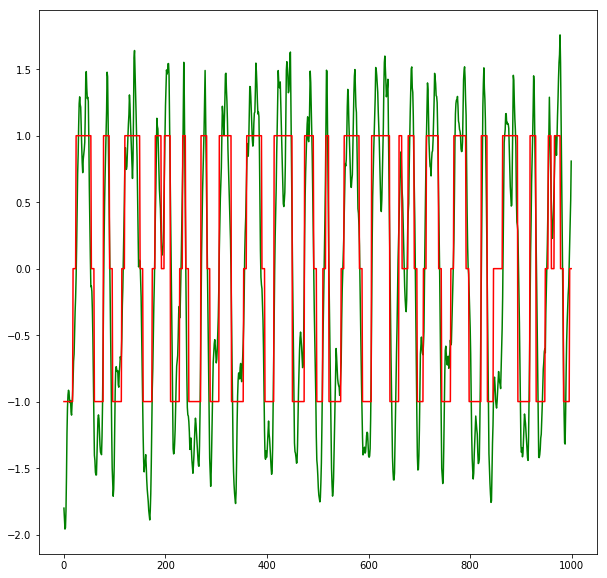

In [8]:
enum = {'a':-1, 'b': 0, 'c':1}
disc_enum = [enum[x] for x in discrete_signal]

plt.figure(figsize=(10,10))
plt.plot(signal[:1000], color='g', label='raw')
plt.plot(disc_enum[:1000], color='r', label='discrete')

In [31]:
# Extract ngram probabilities and training profile based on most frequent ngrams
train_probs = extract_ngram_probs(train_sax)

labels = np.array(y2, copy=True)

train_prof = extract_train_prof(train_probs, thres=1)

# raise an alarm for encountered ngrams in the test signal, not present in the 
# training profile
alarm_regions = extract_alarm_regions(test_sax, train_prof)

In [32]:
# Compute score S
gamma=0.5

predicted_labels = np.zeros_like(labels)
predicted_labels[alarm_regions] = 1

sttd = compute_sttd(labels, predicted_labels)
cm = estimate_confusion_matrix(labels, predicted_labels)
scm = compute_scm(cm)
s = compute_s(labels, predicted_labels,gamma)

print(cm.shape)
print(sttd, scm)
print(s)

(2, 2)
0.21124620060790278 0.5527625177880001
0.38200435919795145


In [39]:
((63/(63+429)) + (3602/(3602+83)))/2

0.5527625177880001

Confusion matrix:  [[  63   83]
 [ 429 3602]]


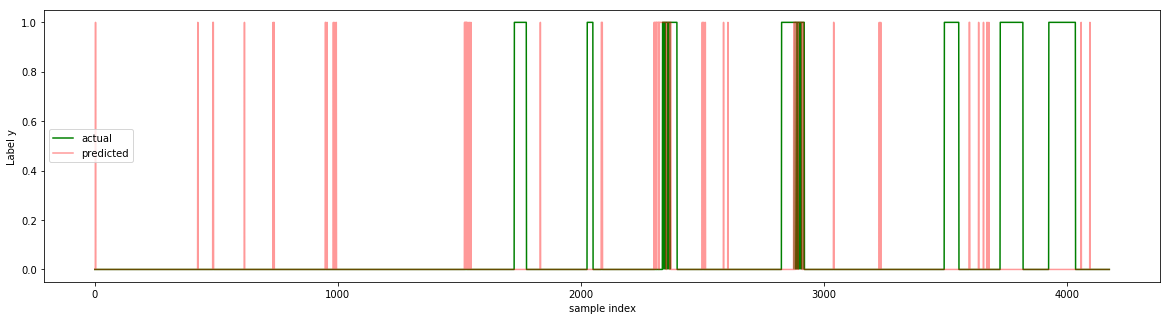

In [35]:
cm = estimate_confusion_matrix(labels, predicted_labels)
print("Confusion matrix: ", cm)
plot(labels, predicted_labels)

In [13]:
window_size = np.array([2, 5, 10, 25, 50, 100, 200])
vocab_size = np.arange(3, 6, dtype=int)
paa_segments = np.array([2,4,8,16,32,64])

signal = X1[:, 0]
test_signal = X2[:, 0]
test_labels = np.array(y2, copy=True)

TP = np.zeros((len(window_size), len(paa_segments), len(vocab_size), len(L)), dtype=int)
FP = np.zeros_like(TP)
S = np.zeros((len(window_size), len(paa_segments), len(vocab_size), len(L)))
for w in range(len(window_size)):
    for p in range(len(paa_segments)):
        for v in range(len(vocab_size)):
            train_sax=sax_via_window(signal, window_size[w], paa_segments[p], vocab_size[v],
               nr_strategy='none', z_threshold=0.01)
            test_sax = sax_via_window(test_signal, window_size[w], paa_segments[p], vocab_size[v],
                         nr_strategy='none')

            train_probs = extract_ngram_probs(train_sax)
            train_prof = extract_train_prof(train_probs, thres=1)
            alarm_regions = extract_alarm_regions(test_sax, train_prof)
            print("Attacks detected: ", len(alarm_regions))
            if not alarm_regions:
                continue


            predicted_labels = np.zeros_like(test_labels)
            predicted_labels[alarm_regions] = 1
            cm = estimate_confusion_matrix(test_labels, predicted_labels)
            print("CM: ", cm)
            TP[w, p, v, l] = cm[0,0]
            FP[w, p, v, l] = cm[0,1]
            s = compute_s(test_labels, predicted_labels, 0.5)
            S[w,p,v,l] = s
            
            

Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0


KeyboardInterrupt: 

In [13]:
def optimal_parameters(train_signal, train_labels, test_signal, test_labels, window_size, paa_segments, vocab_size, gamma):
    S = np.zeros((len(window_size), len(paa_segments), len(vocab_size)))
    
    max_S = 0
    optimal_labels = np.zeros_like(test_labels)
    
    for w in range(len(window_size)):
        for p in range(len(paa_segments)):
            for v in range(len(vocab_size)):
                train_sax=sax_via_window(train_signal, window_size[w], paa_segments[p], vocab_size[v],
                   nr_strategy='none', z_threshold=0.01)
                test_sax = sax_via_window(test_signal, window_size[w], paa_segments[p], vocab_size[v],
                             nr_strategy='none')

                train_probs = extract_ngram_probs(train_sax)
                train_prof = extract_train_prof(train_probs, thres=1)
                alarm_regions = extract_alarm_regions(test_sax, train_prof)

#                 print("Attacks detected: ", len(alarm_regions))
                if not alarm_regions:
                    continue

                predicted_labels = np.zeros_like(test_labels)
                predicted_labels[alarm_regions] = 1

                s = compute_s(test_labels, predicted_labels, gamma)
                if s > max_S:
                    optimal_labels = predicted_labels
                S[w,p,v] = s
                    
        return S, optimal_labels
                    

#### Examined sensor: `L_T1`
First determine the optimal parameters for the discretization to be applied based on the optimal score S (please refer to the comparison task in the report for the definition of score S).

For the visualization of the applied discretization the scaled signal is used (mean=0 and std=1). The function `sax_via_window` used internally applies the same normalization to the input signal, hence we provide it with the original, unscaled signal.

In [24]:
train_signal = X1[:, 0]
train_signal_scaled = X1_scaled[:, 0]
train_labels = np.array(y1, copy=True)
test_signal = X2[:, 0]
test_labels = np.array(y2, copy=True)

window_size = np.array([20, 40, 50, 100, 200])
paa_segments = np.array([2, 4, 8, 16], dtype=int)
vocab_size = np.arange(3, 7, dtype=int)
gamma=0.01

Extract the optimal parameters

In [25]:
S, optimal_labels = optimal_parameters(train_signal, train_labels, test_signal, test_labels,
                                              window_size, paa_segments, vocab_size, 0.01)

The maximum score computed is approx. S=0.592. The optimal parameters are `window_size[0]=20`, hence we are going to use a sliding window of length 20, `paa_segments[3]=16` for Piecewise Aggregate Approximation and `vocab_size[1]=4` so 4 quantized states are going to be used for the discretization.

In [26]:
print("Max S: ", np.max(S))
ind = np.unravel_index(np.argmax(S), S.shape)
print(ind)

Max S:  0.5921299583804134
(0, 3, 1)


Visualizing the computed optimal discretization on a slice of the examined signal. Clearly the discrete signal shows a good fit of the original "raw signal". Perhaps it is too good and we could also use a simpler apporach, with less `paa_segments` and fewer quantized states. However, since this the discretization yielding the highest score S we are proceeding with this one.

By examining carefully the given we can see that 5 states actually occur in the discrete signal. This was quite strange, but it should have something to do with the aggregation applied. By rerunning the discretization this time with 3 and 5 `vocab_size` the discrete signal had the correct number of quantized states, 3 and 5 respectively. Perphaps our intuition that this is a more complex discretization than necessary for the modelled signal is actually true.

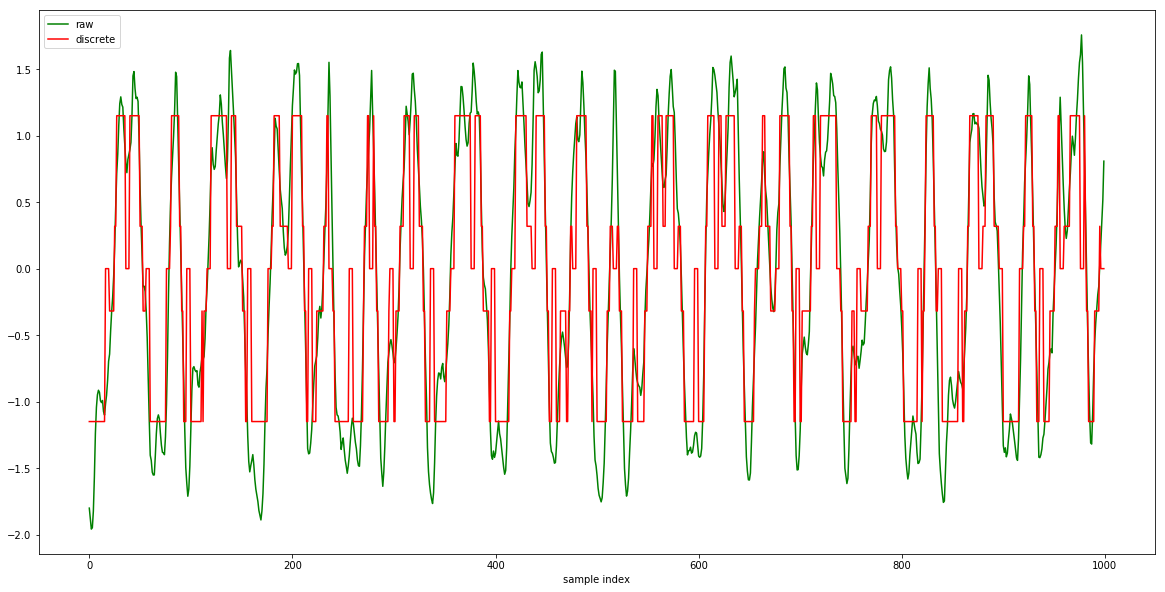

In [27]:
discrete_signal = discretize(train_signal_scaled, window_size[ind[0]], paa_segments[ind[1]], vocab_size[ind[2]])

plt.figure(figsize=(20,10))
plt.plot(train_signal_scaled[:1000], color='g', label = 'raw')
plt.plot(discrete_signal[:1000], color='r', label = 'discrete')
plt.xlabel("sample index")
plt.legend()


In [ ]:
Performance metrics

Confusion matrix:
 [[ 305 1909]
 [ 187 1776]] 

Score: 0.555
Accuracy: 0.498
Precision: 0.138
Recall: 0.620
F1_score: 0.225


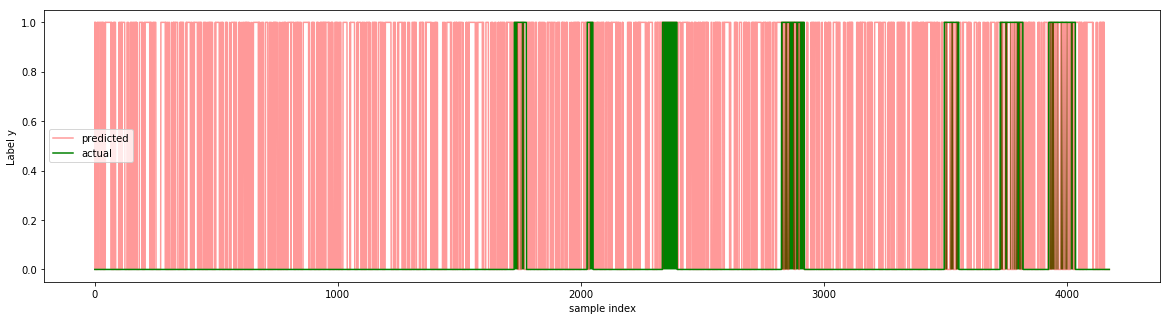

In [28]:
cm = estimate_confusion_matrix(test_labels, optimal_labels)
print("Confusion matrix:\n", cm, "\n")

s = compute_s(test_labels, optimal_labels, gamma)
accuracy, precision, recall, F1_score = performance_metrics(cm)
print("Score: %.3f" %s)
print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" %precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" %F1_score)

plot(test_labels, optimal_labels)

#### Examined sensor: `L_T2`
First determine the optimal parameters for the discretization to be applied based on the optimal score S (please refer to the comparison task in the report for the definition of score S).

In [29]:
train_signal = X1[:, 1]
train_signal_scaled = X1_scaled[:, 1]
train_labels = np.array(y1, copy=True)
test_signal = X2[:, 1]
test_labels = np.array(y2, copy=True)

window_size = np.array([20, 40, 50, 100, 200])
paa_segments = np.array([2, 4, 8, 16], dtype=int)
vocab_size = np.arange(3, 7, dtype=int)
gamma=0.01

Extract the optimal parameters

In [30]:
S, optimal_labels = optimal_parameters(train_signal, train_labels, test_signal, test_labels,
                                              window_size, paa_segments, vocab_size, 0.01)

In [31]:
print("Max S: ", np.max(S))
ind = np.unravel_index(np.argmax(S), S.shape)
print(ind)

Max S:  0.5689694766786371
(0, 3, 3)


Visualizing the discretization

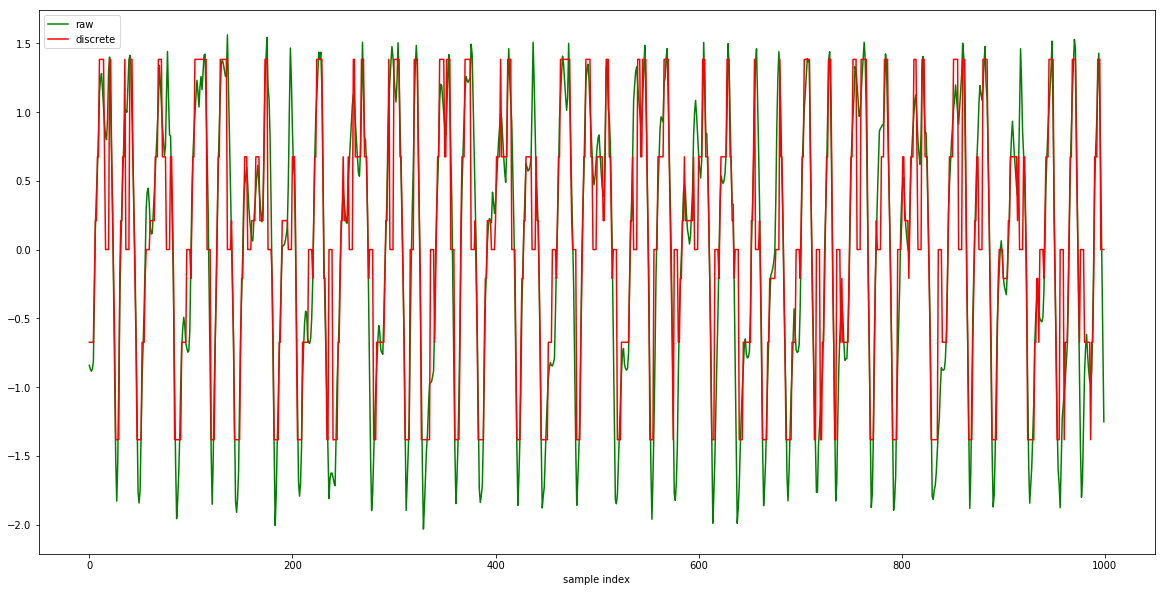

In [32]:
discrete_signal = discretize(train_signal_scaled, window_size[ind[0]], paa_segments[ind[1]], vocab_size[ind[2]])

plt.figure(figsize=(20,10))
plt.plot(train_signal_scaled[:1000], color='g', label = 'raw')
plt.plot(discrete_signal[:1000], color='r', label = 'discrete')
plt.xlabel("sample index")
plt.legend()


Performance metrics

Confusion matrix:
 [[ 273 1566]
 [ 219 2119]] 

Score: 0.569
Accuracy: 0.573
Precision: 0.148
Recall: 0.555
F1_score: 0.234


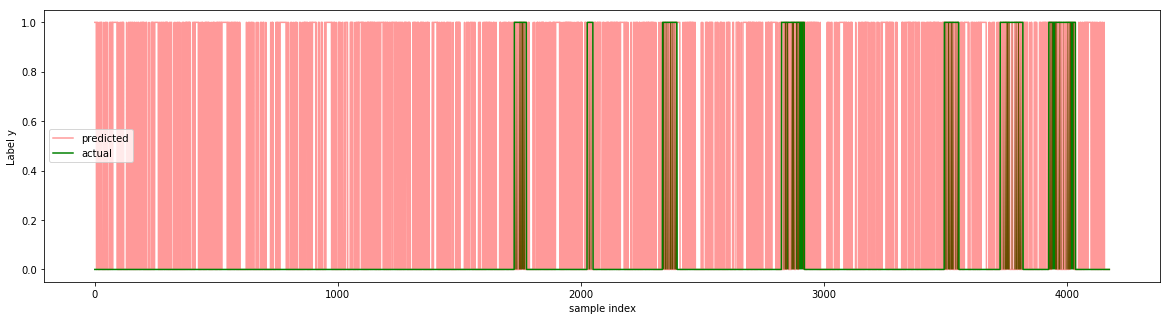

In [33]:
cm = estimate_confusion_matrix(test_labels, optimal_labels)
print("Confusion matrix:\n", cm, "\n")

s = compute_s(test_labels, optimal_labels, gamma)
accuracy, precision, recall, F1_score = performance_metrics(cm)
print("Score: %.3f" %s)
print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" %precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" %F1_score)

plot(test_labels, optimal_labels)

#### Examined sensor: `L_T4`
First determine the optimal parameters for the discretization to be applied based on the optimal score S (please refer to the comparison task in the report for the definition of score S).

In [34]:
train_signal = X1[:, 3]
train_signal_scaled = X1_scaled[:, 3]
train_labels = np.array(y1, copy=True)
test_signal = X2[:, 3]
test_labels = np.array(y2, copy=True)

window_size = np.array([20, 40, 50, 100, 200])
paa_segments = np.array([2, 4, 8, 16], dtype=int)
vocab_size = np.arange(3, 7, dtype=int)
gamma=0.01

Extract the optimal parameters

In [35]:
S, optimal_labels = optimal_parameters(train_signal, train_labels, test_signal, test_labels,
                                              window_size, paa_segments, vocab_size, 0.01)

In [36]:
print("Max S: ", np.max(S))
ind = np.unravel_index(np.argmax(S), S.shape)
print(ind)

Max S:  0.5199481252275209
(0, 2, 2)


Visualizing the discretization

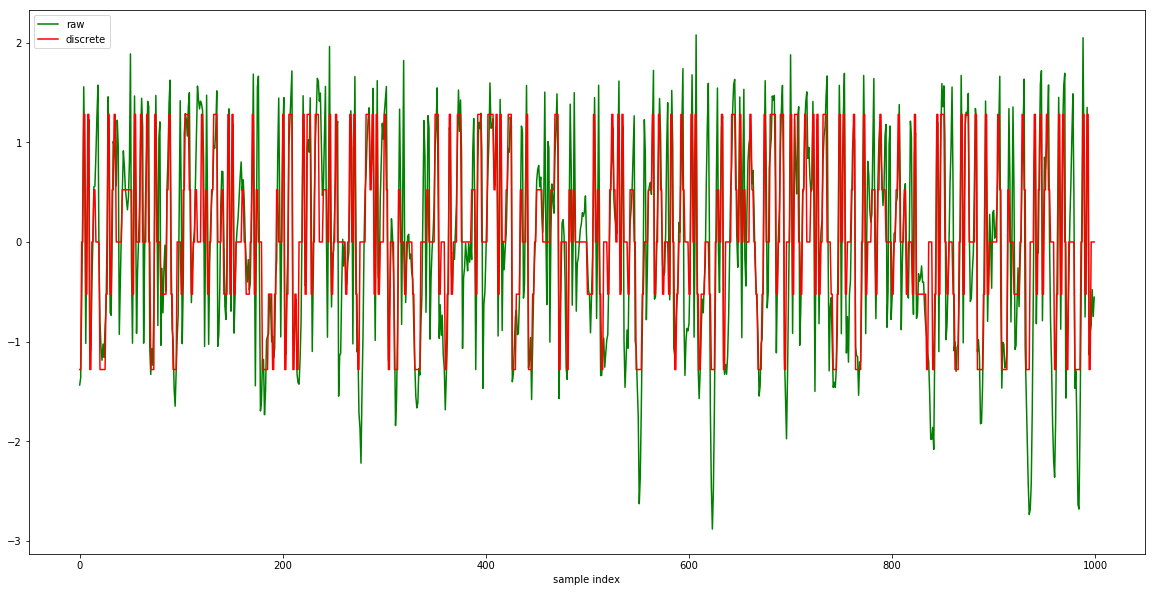

In [37]:
discrete_signal = discretize(train_signal_scaled, window_size[ind[0]], paa_segments[ind[1]], vocab_size[ind[2]])

plt.figure(figsize=(20,10))
plt.plot(train_signal_scaled[:1000], color='g', label = 'raw')
plt.plot(discrete_signal[:1000], color='r', label = 'discrete')
plt.xlabel("sample index")
plt.legend()


Performance metrics

Confusion matrix:
 [[ 492 3659]
 [   0   26]] 

Score: 0.508
Accuracy: 0.124
Precision: 0.119
Recall: 1.000
F1_score: 0.212


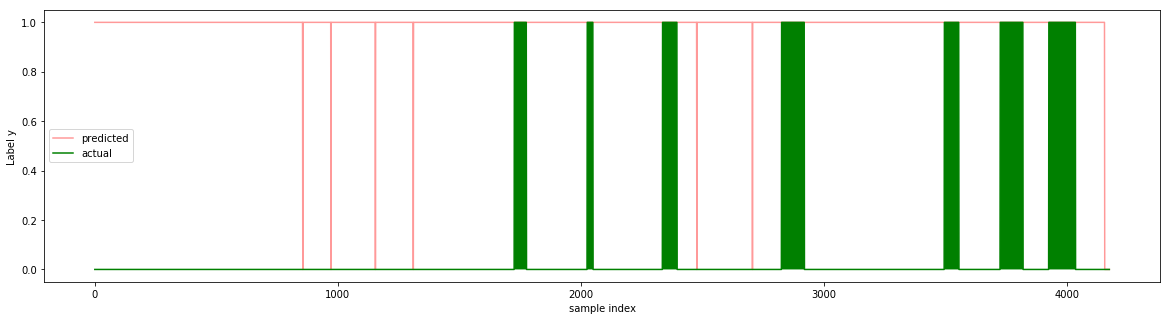

In [38]:
cm = estimate_confusion_matrix(test_labels, optimal_labels)
print("Confusion matrix:\n", cm, "\n")

s = compute_s(test_labels, optimal_labels, gamma)
accuracy, precision, recall, F1_score = performance_metrics(cm)
print("Score: %.3f" %s)
print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" %precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" %F1_score)

plot(test_labels, optimal_labels)

#### Examined sensor: `L_T7`
First determine the optimal parameters for the discretization to be applied based on the optimal score S (please refer to the comparison task in the report for the definition of score S).

In [39]:
train_signal = X1[:, 6]
train_signal_scaled = X1_scaled[:, 6]
train_labels = np.array(y1, copy=True)
test_signal = X2[:, 6]
test_labels = np.array(y2, copy=True)

window_size = np.array([20, 40, 50, 100, 200])
paa_segments = np.array([2, 4, 8, 16], dtype=int)
vocab_size = np.arange(3, 7, dtype=int)
gamma=0.01

Extract the optimal parameters

In [40]:
S, optimal_labels = optimal_parameters(train_signal, train_labels, test_signal, test_labels,
                                              window_size, paa_segments, vocab_size, 0.01)

In [41]:
print("Max S: ", np.max(S))
ind = np.unravel_index(np.argmax(S), S.shape)
print(ind)

Max S:  0.5341159446669094
(0, 3, 0)


Visualizing the discretization

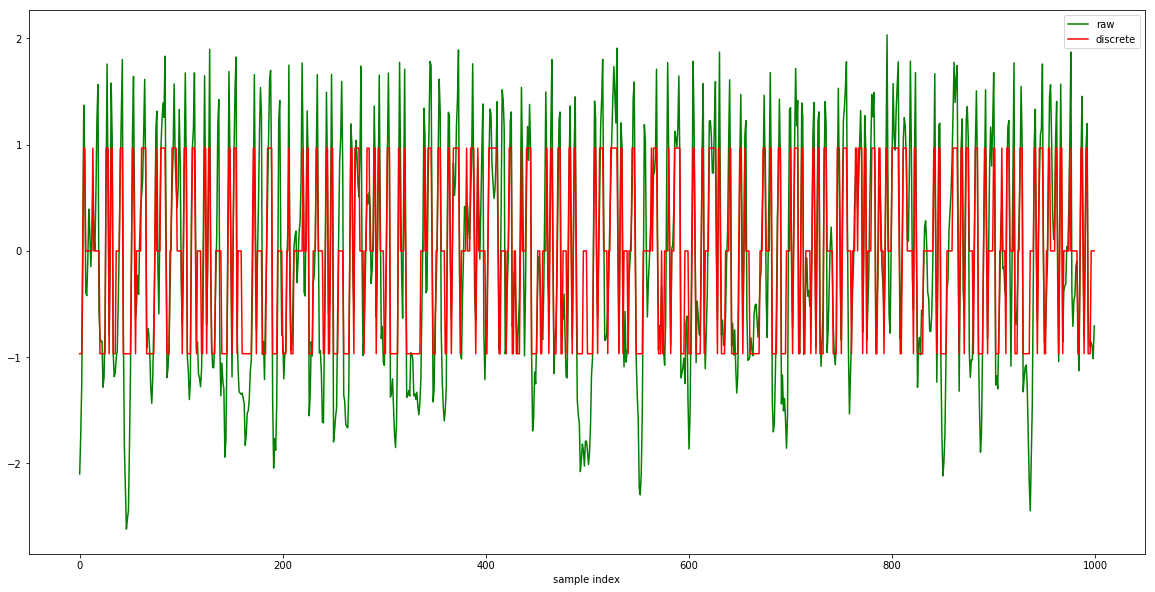

In [42]:
discrete_signal = discretize(train_signal_scaled, window_size[ind[0]], paa_segments[ind[1]], vocab_size[ind[2]])

plt.figure(figsize=(20,10))
plt.plot(train_signal_scaled[:1000], color='g', label = 'raw')
plt.plot(discrete_signal[:1000], color='r', label = 'discrete')
plt.xlabel("sample index")
plt.legend()


Performance metrics

Confusion matrix:
 [[ 492 3658]
 [   0   27]] 

Score: 0.509
Accuracy: 0.124
Precision: 0.119
Recall: 1.000
F1_score: 0.212


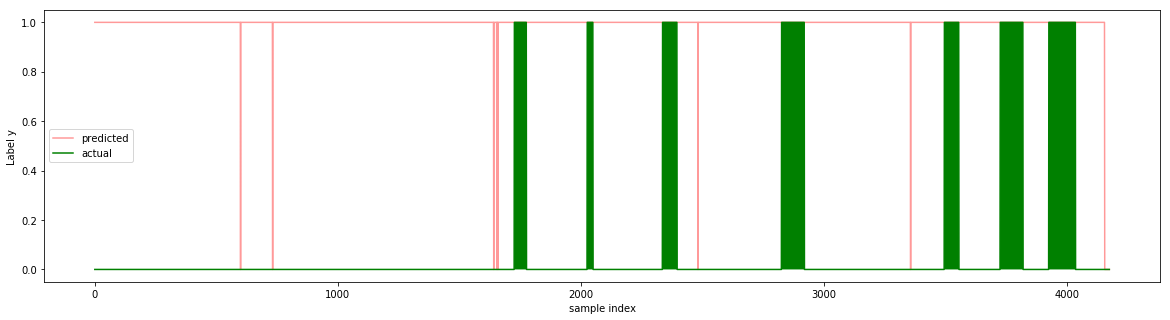

In [43]:
cm = estimate_confusion_matrix(test_labels, optimal_labels)
print("Confusion matrix:\n", cm, "\n")

s = compute_s(test_labels, optimal_labels, gamma)
accuracy, precision, recall, F1_score = performance_metrics(cm)
print("Score: %.3f" %s)
print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" %precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" %F1_score)

plot(test_labels, optimal_labels)

#### Examined sensor: `F_PU1`
First determine the optimal parameters for the discretization to be applied based on the optimal score S (please refer to the comparison task in the report for the definition of score S).

In [44]:
train_signal = X1[:, 7]
train_signal_scaled = X1_scaled[:, 7]
train_labels = np.array(y1, copy=True)
test_signal = X2[:, 7]
test_labels = np.array(y2, copy=True)

window_size = np.array([20, 40, 50, 100, 200])
paa_segments = np.array([2, 4, 8, 16], dtype=int)
vocab_size = np.arange(3, 7, dtype=int)
gamma=0.01

Extract the optimal parameters

In [45]:
S, optimal_labels = optimal_parameters(train_signal, train_labels, test_signal, test_labels,
                                              window_size, paa_segments, vocab_size, 0.01)

In [46]:
print("Max S: ", np.max(S))
ind = np.unravel_index(np.argmax(S), S.shape)
print(ind)

Max S:  0.5470029102393732
(0, 3, 1)


Visualizing the discretization

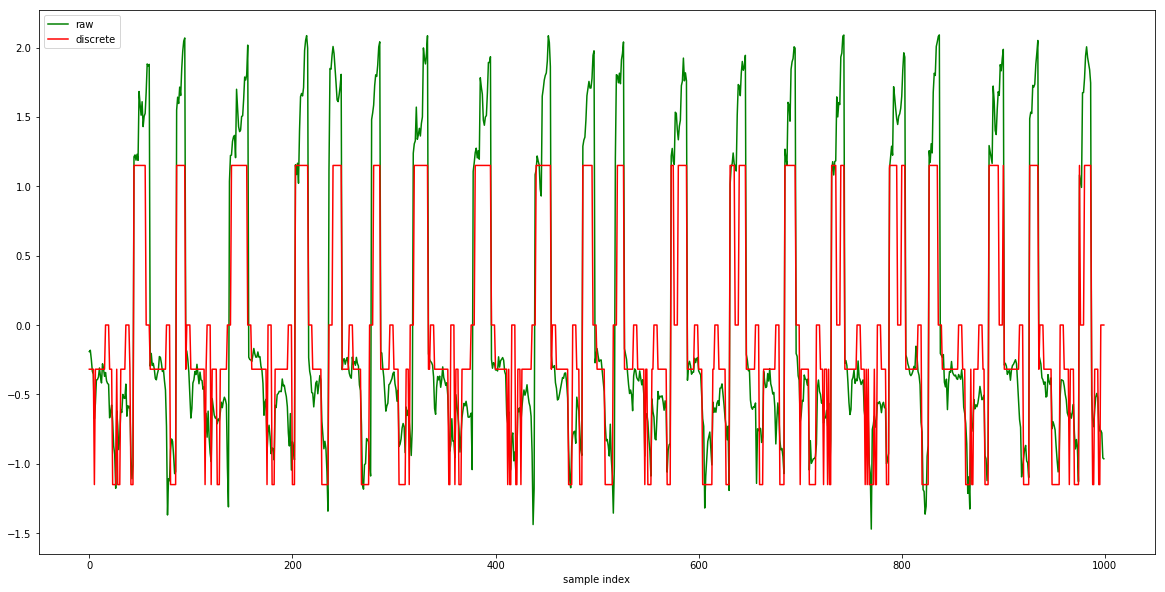

In [47]:
discrete_signal = discretize(train_signal_scaled, window_size[ind[0]], paa_segments[ind[1]], vocab_size[ind[2]])

plt.figure(figsize=(20,10))
plt.plot(train_signal_scaled[:1000], color='g', label = 'raw')
plt.plot(discrete_signal[:1000], color='r', label = 'discrete')
plt.xlabel("sample index")
plt.legend()


Performance metrics

Confusion matrix:
 [[ 320 2226]
 [ 172 1459]] 

Score: 0.528
Accuracy: 0.426
Precision: 0.126
Recall: 0.650
F1_score: 0.211


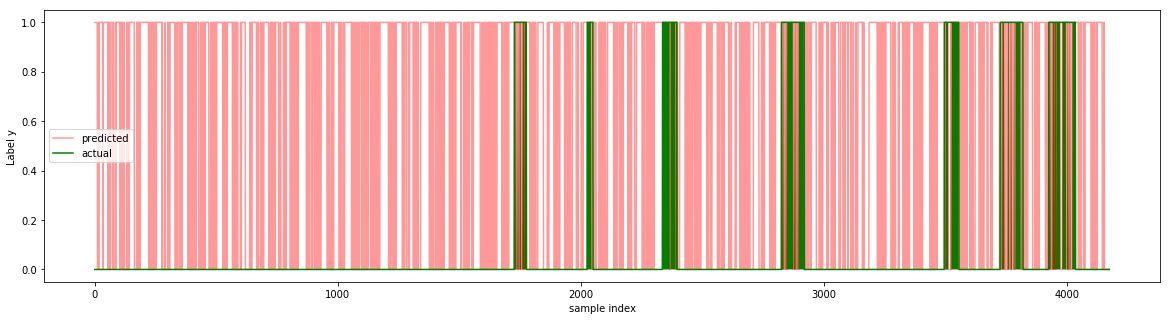

In [48]:
cm = estimate_confusion_matrix(test_labels, optimal_labels)
print("Confusion matrix:\n", cm, "\n")

s = compute_s(test_labels, optimal_labels, gamma)
accuracy, precision, recall, F1_score = performance_metrics(cm)
print("Score: %.3f" %s)
print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" %precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" %F1_score)

plot(test_labels, optimal_labels)

#### Examined sensor: `F_PU2`
First determine the optimal parameters for the discretization to be applied based on the optimal score S (please refer to the comparison task in the report for the definition of score S).

In [49]:
train_signal = X1[:, 8]
train_signal_scaled = X1_scaled[:, 8]
train_labels = np.array(y1, copy=True)
test_signal = X2[:, 8]
test_labels = np.array(y2, copy=True)

window_size = np.array([20, 40, 50, 100, 200])
paa_segments = np.array([2, 4, 8, 16], dtype=int)
vocab_size = np.arange(3, 7, dtype=int)
gamma=0.01

Extract the optimal parameters

In [50]:
S, optimal_labels = optimal_parameters(train_signal, train_labels, test_signal, test_labels,
                                              window_size, paa_segments, vocab_size, 0.01)

In [51]:
print("Max S: ", np.max(S))
ind = np.unravel_index(np.argmax(S), S.shape)
print(ind)

Max S:  0.5333402175211596
(0, 3, 1)


Visualizing the discretization

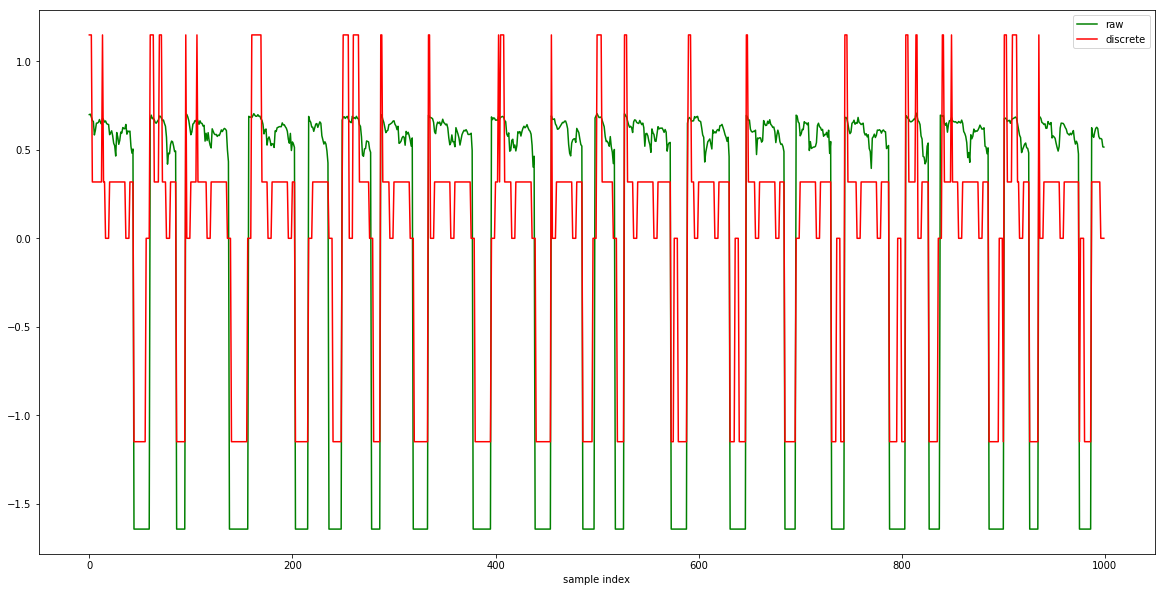

In [52]:
discrete_signal = discretize(train_signal_scaled, window_size[ind[0]], paa_segments[ind[1]], vocab_size[ind[2]])

plt.figure(figsize=(20,10))
plt.plot(train_signal_scaled[:1000], color='g', label = 'raw')
plt.plot(discrete_signal[:1000], color='r', label = 'discrete')
plt.xlabel("sample index")
plt.legend()


Performance metrics

Confusion matrix:
 [[ 201 1370]
 [ 291 2315]] 

Score: 0.522
Accuracy: 0.602
Precision: 0.128
Recall: 0.409
F1_score: 0.195


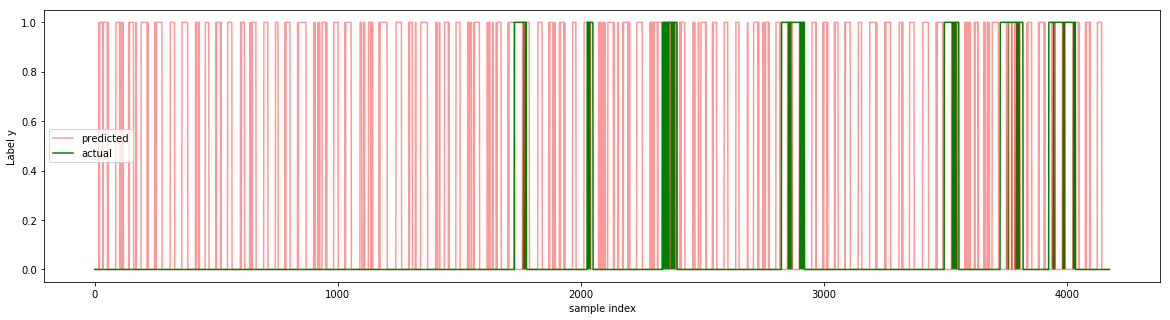

In [53]:
cm = estimate_confusion_matrix(test_labels, optimal_labels)
print("Confusion matrix:\n", cm, "\n")

s = compute_s(test_labels, optimal_labels, gamma)
accuracy, precision, recall, F1_score = performance_metrics(cm)
print("Score: %.3f" %s)
print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" %precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" %F1_score)

plot(test_labels, optimal_labels)